# Bird image classification - Detection
### Ariane ALIX
### 26/11/2019


The goal of this Notebook is to detect the birds in the pictures to recrop around them. The idea is to avoid errors due to the analysis of the background during the training and utilization of the Neural Networks.


In [0]:
%load_ext autoreload

%autoreload 2

In [0]:
import os
import numpy as np
import torchvision
import torch
import tqdm
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image

from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Object Reco clean New')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Loading the images datasets


In [0]:
from torchvision import datasets

train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('bird_dataset/train_images',transform = transforms.ToTensor()),
        batch_size=1, shuffle=False, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset/val_images',transform = transforms.ToTensor()),
    batch_size=1, shuffle=False, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset/test_images',transform = transforms.ToTensor()),
    batch_size=64, shuffle=False, num_workers=1)


### Set up the model with 2 classes : background and bird

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_mask = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

use_cuda = torch.cuda.is_available()
if use_cuda :
    model.cuda()
    model_mask.cuda()
else:
    print('Using CPU')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 108MB/s]
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 113MB/s]


In [0]:
def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = [255,255,255]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

In [0]:
def get_prediction_mask(img_path, threshold, label):
  img = Image.open(img_path)
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img)

  if use_cuda :
    img=img.cuda()

  pred = model_mask([img])
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())

  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  
  #check if there is a match
  if pred_t != []:
      pred_t= pred_t[-1]

      masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
      pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
      pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]

      #reshaping if needed
      if len(masks.shape)==2:
        masks=masks.reshape(1,masks.shape[0],masks.shape[1])

      masks = masks[np.array(pred_class)==label]#keeping the best 'bird' detections
      pred_boxes = pred_boxes[pred_class==label]
      pred_class = pred_class[pred_class==label]
      
      return masks, pred_boxes, pred_class

  else:
      return -1,-1,-1

In [0]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3,label='bird',display=False):
    masks, boxes, pred_cls = get_prediction_mask(img_path, threshold,label)

    # if mask=-1 no bird was found
    if type(masks)!=int:

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb_mask = random_colour_masks(masks[0])

        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        cv2.rectangle(img, boxes[0], boxes[1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls, boxes[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

        if display:
            plt.figure(figsize=(10,5))
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.show()

            plt.figure(figsize=(10,5))
            plt.imshow(rgb_mask)
            plt.xticks([])
            plt.yticks([])
            plt.show()

        return rgb_mask, boxes, pred_cls
    else:
        return -1,-1,-1

### Applying the pre-trained model without training

#### Testing

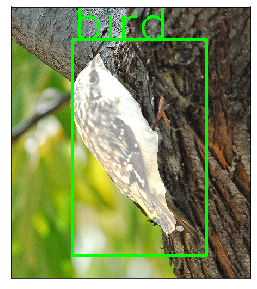

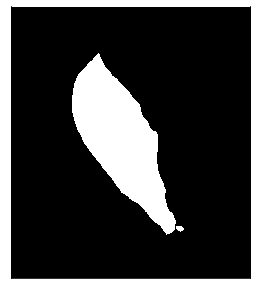

[(113.46181, 61.156975), (359.98276, 458.4622)] bird


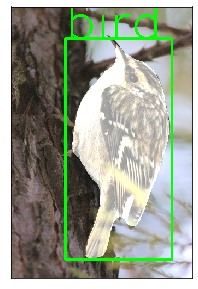

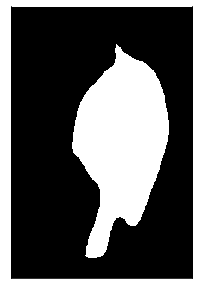

[(99.441216, 59.02886), (294.5276, 466.3185)] bird


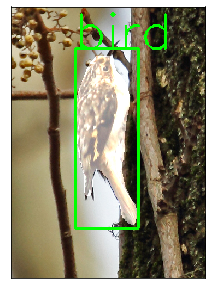

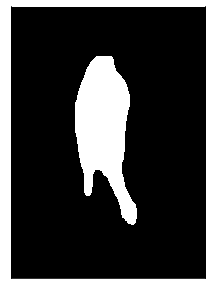

[(117.89948, 78.13339), (233.57587, 408.19305)] bird


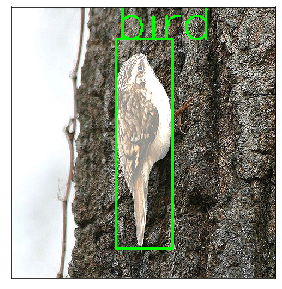

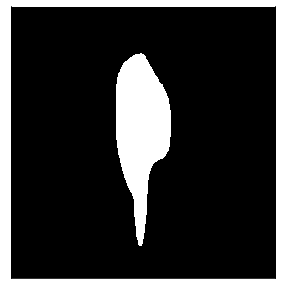

[(192.1166, 60.114975), (296.03336, 445.66513)] bird


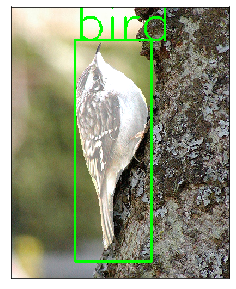

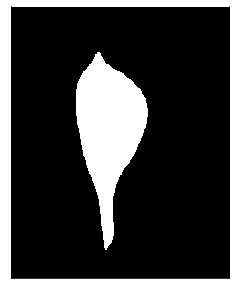

[(117.639885, 62.30435), (257.1735, 469.69046)] bird


In [11]:
directory='bird_dataset/train_images/'

i=0
for f in os.listdir(directory):
    for pic in os.listdir(directory+f):
        data = directory+f+'/'+pic
        
        #pred_boxes, pred_class = get_prediction(data[0])
        model_mask.eval()
        mask, pred_box, pred_class=instance_segmentation(data,threshold=0.6,display=True)
        # sum up batch loss
        print( pred_box, pred_class)
        i+=1
        if i==5:
            break
    if i==5:
            break

### Delete the background, crop the images and save them in a new directory


In [0]:
def process_images(directory):
    i=0
    for f in os.listdir(directory):
        for pic in os.listdir(directory+f):
            data = directory+f+'/'+pic
            model_mask.eval()
            mask, pred_box, pred_class=instance_segmentation(data,threshold=0.6,display=False)

            # if mask=-1 no bird was found
            if type(mask)!=int:
                ### Keep only the bird
                img= cv2.imread(data)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image=np.multiply(img/255,mask/255) #keeps only the bird

                ### Change the background to an unique value (avg of background)
                bg=np.multiply(img/255,1-(mask/255))
                #get the average of the background
                bg_r=np.mean(bg[:,:,0])
                bg_g=np.mean(bg[:,:,1])
                bg_b=np.mean(bg[:,:,2])     
                avg_bg=np.multiply(1-(mask/255),[bg_r,bg_g,bg_b]) #average background

                ### Summing picture of bird-only + avg background
                final_image=image+avg_bg

                ### Crop the image accoding to the bounding bbox, squaring it automatically
                top,left=pred_box[0][1], pred_box[0][0]
                height=pred_box[1][1]-pred_box[0][1]
                width=pred_box[1][0]- pred_box[0][0]
                final_image=torchvision.transforms.functional.crop(Image.fromarray((final_image*255).astype('uint8')).convert('RGB'),top,left, height, width )       
                
                ### Save the resulting image
                new_dir='detected_'+directory+f+'/'
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir) #Creating new folder
                final_image.save(new_dir+pic)


                ### Displaying the first results
                i+=1
                if i<=5:
                    print(pred_box, pred_class)
                    plt.imshow(final_image)
                    plt.show()

            else: #saving orignal picture
                new_dir='detected_'+directory+f+'/'
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir) #Creating new folder
                Image.fromarray((img*255).astype('uint8')).convert('RGB').save(new_dir+pic)

[(113.46181, 61.156975), (359.98276, 458.4622)] bird


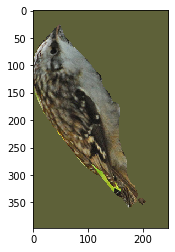

[(99.441216, 59.02886), (294.5276, 466.3185)] bird


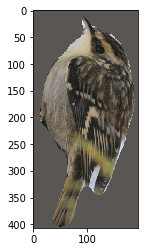

[(117.89948, 78.13339), (233.57587, 408.19305)] bird


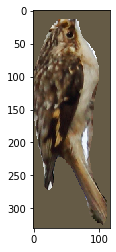

[(192.1166, 60.114975), (296.03336, 445.66513)] bird


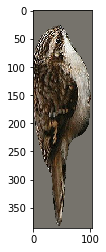

[(117.639885, 62.30435), (257.1735, 469.69046)] bird


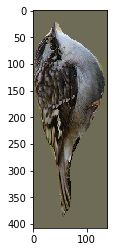

In [15]:
process_images(directory='bird_dataset/train_images/')

[(65.09138, 44.609947), (275.37204, 295.85574)] bird


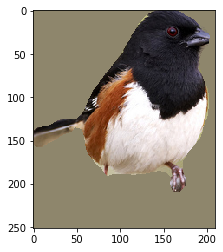

[(135.24954, 91.10859), (287.8175, 316.8382)] bird


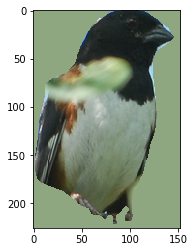

[(85.9283, 98.61644), (295.1061, 305.07626)] bird


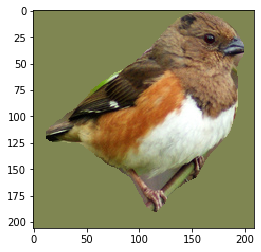

[(97.46376, 84.40162), (187.56165, 277.19852)] bird


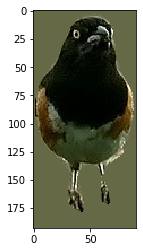

[(67.75631, 32.363617), (479.97647, 293.7076)] bird


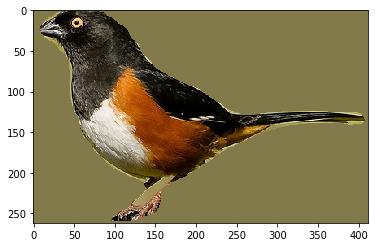

In [16]:
process_images(directory='bird_dataset/val_images/')

[(104.7046, 198.98517), (365.21716, 512.4464)] bird


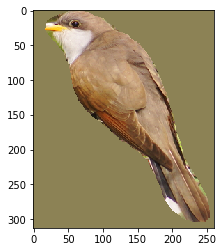

[(97.30449, 162.03957), (189.22044, 244.93742)] bird


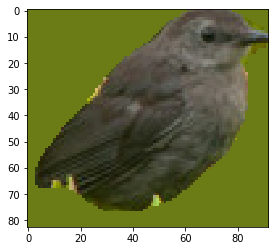

[(119.98011, 87.98192), (375.071, 277.64462)] bird


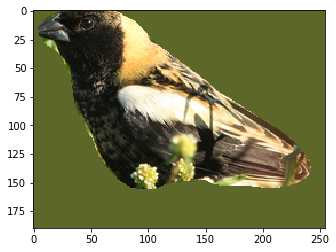

[(96.08072, 197.63013), (295.69788, 465.9222)] bird


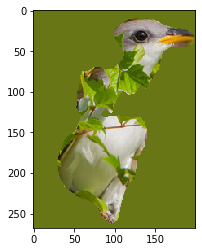

[(17.660446, 15.235577), (325.40604, 293.449)] bird


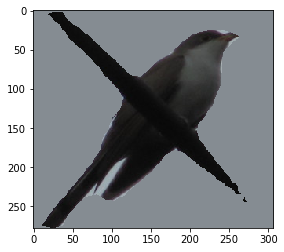

In [17]:
process_images(directory='bird_dataset/test_images/')